In [2]:
# Basic imports & versions
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
import torch as th

# SB3
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

# Utils and CityLearn
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger, DiscretizeActionWrapper
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-27 16:38:53.581121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 16:38:53.605914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756305533.635659  313619 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756305533.644130  313619 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756305533.665792  313619 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


In [3]:
# Configuration (kept consistent with other notebooks)
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10

# Action label helpers (for consistent plotting with RBC/DQN)
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
NAME_TO_FRAC = {
    '100%_discharge': -1.0,
    '50%_discharge': -0.5,
    'idle': 0.0,
    '50%_charge': 0.5,
    '100%_charge': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)

In [4]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

# Set pricing file on all buildings
price_file = PRICING_FILE
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

# Narrow to electrical storage and core observations (same as other notebooks)
schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


In [5]:
# Keep only one building for Discrete(5)
one_building = "Building_1"
schema_1b = dict(schema)
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

# Create base env
env = CityLearnEnv(schema_1b, central_agent=True)

# Basic checks
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {b.name: b.electrical_storage.capacity for b in env.buildings})
print('Action_space:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

# Build & Train A2C
log_dir = os.path.join(os.getcwd(), 'logs', 'a2c')
os.makedirs(log_dir, exist_ok=True)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = DiscretizeActionWrapper(train_env, n_bins=5)   # Discrete(5): [-1,-0.5,0,0.5,1]
print('Train action_space:', train_env.action_space)       # should be Discrete(5)
train_env = Monitor(train_env, filename=os.path.join(log_dir, "monitor.csv"))

logger = PPOTrainLogger()  # generic callback capturing ep_df/step stats

TOTAL_TIMESTEPS = 2208 * 40

model = A2C(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=0.0001,
    ent_coef=0.5,
    seed=0,
    verbose=1,
    policy_kwargs=dict(net_arch=[256, 256], activation_fn=th.nn.ReLU),
    # learning_rate=7e-4,  # default
    # n_steps=5, gae_lambda=1.0, gamma=0.99, ent_coef=0.0
)

t0 = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-t0):.2f} seconds")
model.save("a2c_01")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-27_16-38-59'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6
Train action_space: Discrete(5)
Using cuda device
Wrapping the env in a DummyVecEnv.


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Total time elapsed for 88320 steps: 0.34 seconds


In [ ]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)
print('Eval action_space:', eval_env.action_space)

model = A2C.load("a2c_01")

# Enhanced evaluation: collect actions and rewards, print KPIs and timings.
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False):
    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    t_global_start = time.time()

    def action_to_frac(env, action, b_idx=0):
        # Returns per-dimension action as fractions in [-1,1]
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            # Box: already continuous in [-1,1]
            return np.asarray(action, dtype=np.float32)

    for ep in range(1, episodes+1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            # Log fractions (fixes wrong histogram)
            action_logged = action_to_frac(env, action, b_idx=0)
            action_list.append(action_logged)

            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            ep_ret += float(r)
            step_rewards.append(float(r))
            ep_len += 1
            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))
        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)
        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")
        print("KPIs:", kpis)

    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)
    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Run evaluation (stochastic like PPO plots)
metrics_stoch, step_rewards_stoch, kpis_stoch, actions_stoch = evaluate_with_metrics(
    model, eval_env, episodes=EVAL_EPISODES, deterministic=False
)

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-27_16-39-03'
Eval action_space: Discrete(5)


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


[Eval] Ep 1/10 return=-293.978 len=2207 mean=-0.133 time=141.87s speed=15.6 steps/s
KPIs:                                     cost_function     value        name  \
0                           all_time_peak_average  0.042849    District   
1         annual_normalized_unserved_energy_total  0.019347    District   
2                          carbon_emissions_total  1.127583    District   
3                                      cost_total  1.116862    District   
4             daily_one_minus_load_factor_average  1.370100    District   
5                              daily_peak_average  0.000995    District   
6                   discomfort_cold_delta_average  1.396475    District   
7                   discomfort_cold_delta_maximum  4.770788    District   
8                   discomfort_cold_delta_minimum  0.000000    District   
9                      discomfort_cold_proportion  0.274357    District   
10                   discomfort_hot_delta_average  0.132081    District   
11        

In [ ]:
# Quick learning check on training episodes
if hasattr(logger, 'ep_df') and len(logger.ep_df):
    ep_df = logger.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['return'].head(first_n).mean()
    last_mean  = ep_df['return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in logger.ep_df')

No episode returns in logger.ep_df


In [ ]:
# Plots (same as PPO, quantized to RBC-like 5 bins for comparability)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose a building to visualize
building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map continuous action to 5 RBC-like labels by nearest of [-1,-0.5,0,0.5,1]
bin_centers = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
def frac_to_label_idx(vals: np.ndarray) -> np.ndarray:
    # vals: (...,) in [-1,1]; INT_TO_FRAC ordered like ACTION_LABELS
    return np.argmin(np.abs(vals[..., None] - INT_TO_FRAC[None, :]), axis=-1)

# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]   # already fractions from evaluate_with_metrics
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'A2C Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
# Label y-axis with discrete action names
ax = plt.gca()
ax.set_yticks(INT_TO_FRAC.tolist())
ax.set_yticklabels(ACTION_LABELS)
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
labels_idx = frac_to_label_idx(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
plt.figure(figsize=(4,3))
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


# ----- Plot 3, 4, 5: Reward vs Pricing, Solar Generation, Net Load -----
step_rewards_all = step_rewards_stoch  # flattened across eval episodes
ep1_len = int(ep_lengths[0])
ep1_rewards = step_rewards_all[:ep1_len]
window_r = 200
window_x = 24
ep1_reward_ma = pd.Series(ep1_rewards).rolling(window_r, min_periods=1).mean().to_numpy()
price_ep1_ma = pd.Series(prc['electricity_pricing'].values[:ep1_len]).rolling(window_x, min_periods=1).mean().to_numpy()
t = np.arange(ep1_len)

bld_file = schema['buildings'][building_name]['energy_simulation']
bld_path = os.path.join(ROOT_DIR, bld_file)
bld_df = pd.read_csv(bld_path)
solar_ep1_ma = pd.Series(bld_df['solar_generation'].values[:ep1_len]).rolling(window_x, min_periods=1).mean().to_numpy()


# 4) Reward vs Net Load (Episode 1)
net_col_candidates = ['net_electricity_consumption', 'net_electricity_consumption_without_storage', 'non_shiftable_load']
net_col = next((c for c in net_col_candidates if c in bld_df.columns), None)
if net_col is None:
    raise KeyError(f"None of {net_col_candidates} found in building energy file columns: {list(bld_df.columns)[:20]}...")
net_ep1_ma = pd.Series(bld_df[net_col].values[:ep1_len]).rolling(window_x, min_periods=1).mean().to_numpy()
fig, ax1 = plt.subplots(figsize=(12,3.5))
ax1.plot(t, ep1_reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_ylabel(f'MA Reward ({window_r})', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Timestep'); ax1.grid(True, axis='x', alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(t, net_ep1_ma, color='C4', alpha=0.9, label=f'Net Load MA (w={window_x})')
ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='lower left', frameon=False)
ax1.set_title(f'Episode 1: Reward MA vs Net Load - {building_name}')
plt.tight_layout(); plt.show()


# 5) Reward vs Electricity Price (Episode 1)
fig, ax1 = plt.subplots(figsize=(12,3.5))
ax1.plot(t, ep1_reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_ylabel(f'MA Reward ({window_r})', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Timestep'); ax1.grid(True, axis='x', alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(t, price_ep1_ma, color='C0', alpha=0.9, label=f'Price MA (w={window_x})')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='lower left', frameon=False)
ax1.set_title(f'Episode 1: Reward MA vs Electricity Price - {building_name}')
plt.tight_layout(); plt.show()


# 6) Reward vs Solar Generation (Episode 1)
fig, ax1 = plt.subplots(figsize=(12,3.5))
ax1.plot(t, ep1_reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_ylabel(f'MA Reward ({window_r})', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Timestep'); ax1.grid(True, axis='x', alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(t, solar_ep1_ma, color='C2', alpha=0.9, label=f'Solar Gen MA (w={window_x})')
ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='lower left', frameon=False)
ax1.set_title(f'Episode 1: Reward MA vs Solar Generation - {building_name}')
plt.tight_layout(); plt.show()

NameError: name 'eval_env' is not defined

Plotting actions for building: Building_1 (index 0)


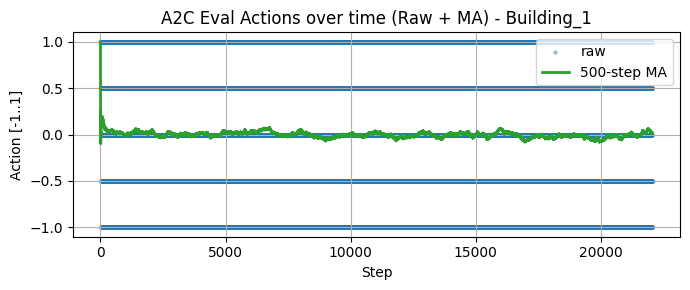

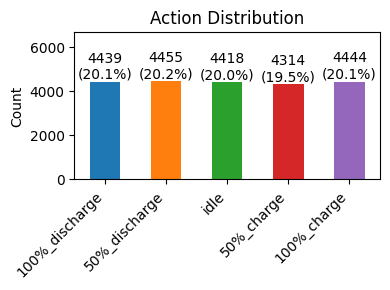

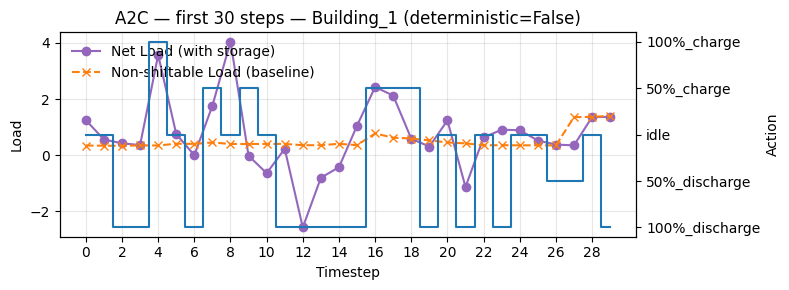

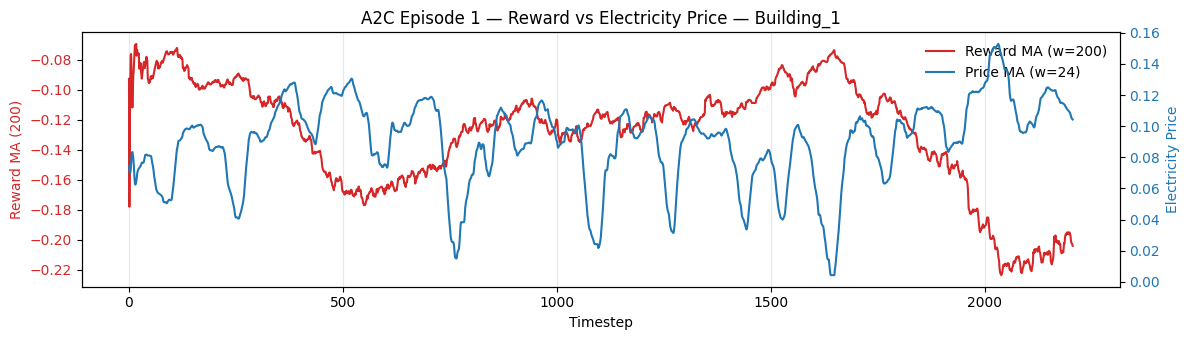

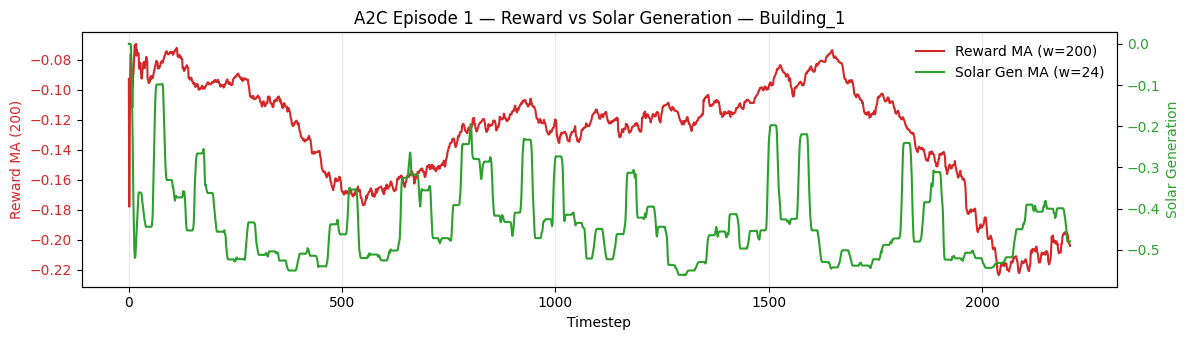

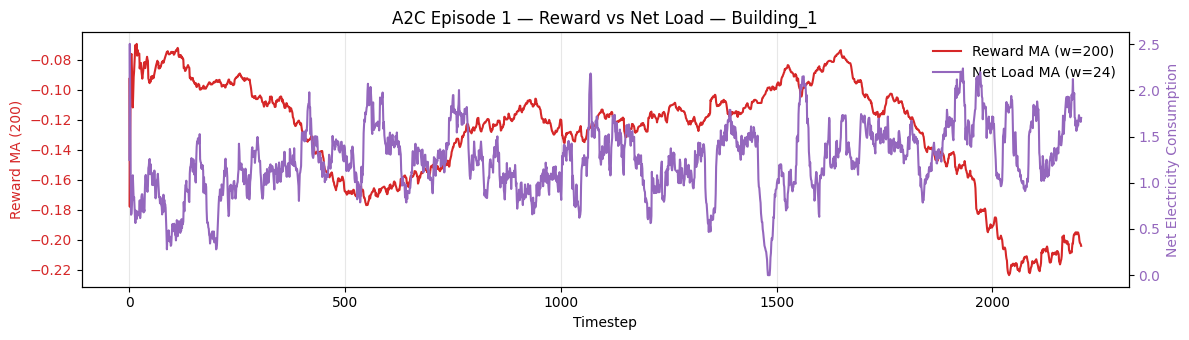

In [ ]:
# 6 A2C plots matching the PPO ones
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv

# Choose a building to visualize
building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
# actions_stoch is collected by evaluate_with_metrics (fractions in [-1,1])
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map fractions to 5 RBC-like bins by nearest of INT_TO_FRAC
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
def frac_to_label_idx(vals: np.ndarray) -> np.ndarray:
    return np.argmin(np.abs(vals[..., None] - INT_TO_FRAC[None, :]), axis=-1)

# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]   # already fractions from evaluate_with_metrics
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'A2C Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
# Label y-axis with discrete action names
ax = plt.gca()
ax.set_yticks(INT_TO_FRAC.tolist())
ax.set_yticklabels(ACTION_LABELS)
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
labels_idx = frac_to_label_idx(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
plt.figure(figsize=(4,3))
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()

# ----- Plot 3,4,5,6: First 20 steps + Reward vs Price/Solar/Net -----

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def capture_ep_series_a2c(model, env, building_name="Building_1", deterministic=True, max_steps=None):
    """Run one episode (or first max_steps) and capture per-step action, reward, and base env series."""
    base = unwrap_to_citylearn(env)

    # Building index
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)
    b = base.buildings[b_idx]

    # Run rollout
    obs, _ = env.reset()
    done, steps = False, 0
    t, a_id_list, a_frac_list, rew_list = [], [], [], []
    net_true, nsl_true, price_true, solar_true = [], [], [], []

    while not done and (max_steps is None or steps < max_steps):
        act, _ = model.predict(obs, deterministic=deterministic)

        # Discrete action id -> fraction
        if isinstance(env.action_space, gym.spaces.Discrete):
            a_id = int(act)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a_id = int(np.asarray(act).reshape(-1)[b_idx])
        else:
            val = float(np.asarray(act).reshape(-1)[b_idx])
            a_id = int(np.argmin(np.abs(INT_TO_FRAC - val)))
        a_frac = float(INT_TO_FRAC[a_id])

        obs, r, terminated, truncated, _ = env.step(act)
        done = bool(terminated or truncated)

        ts_now = b.time_step
        ts_idx = max(0, ts_now - 1)
        net_now = float(b.net_electricity_consumption[ts_now])
        net_idx = float(b.net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(b.non_shiftable_load[ts_now])
        nsl_idx = float(b.non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        price = float(b.pricing.electricity_pricing[ts_now]) if b.pricing is not None else np.nan
        solar = float(b.solar_generation[ts_now])

        t.append(steps)
        a_id_list.append(a_id)
        a_frac_list.append(a_frac)
        rew_list.append(float(r))
        net_true.append(net_use)
        nsl_true.append(nsl_use)
        price_true.append(price)
        solar_true.append(solar)

        steps += 1

    df = pd.DataFrame({
        't': np.arange(len(t)),
        'action_id': a_id_list,
        'action_frac': a_frac_list,
        'reward': rew_list,
        'net_load': net_true,
        'non_shiftable_load': nsl_true,
        'price': price_true,
        'solar_generation': solar_true,
    })
    return df, building_name

def plot_first_30_steps_actions_vs_loads_a2c(model, env, building_name="Building_1", deterministic=True):
    """Plot first 30 steps: net load vs non-shiftable load with action (discrete bins in [-1..1])."""
    df30, bname = capture_ep_series_a2c(model, env, building_name, deterministic=deterministic, max_steps=30)

    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(8, 3))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', frameon=False)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['100%_discharge','50%_discharge','idle','50%_charge','100%_charge'])

    plt.title(f'A2C — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

def a2c_ep1_reward_vs_series(model, env, building_name="Building_1", deterministic=True):
    """Three plots: Reward vs Price, Solar, Net for episode 1."""
    df, bname = capture_ep_series_a2c(model, env, building_name, deterministic=deterministic, max_steps=None)

    window_reward = 200
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    # 1) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
    ax1.set_title(f'A2C Episode 1 — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    # 2) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
    ax1.set_title(f'A2C Episode 1 — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()

    # 3) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
    ax1.set_title(f'A2C Episode 1 — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

# Run the updated plots
plot_first_30_steps_actions_vs_loads_a2c(model, eval_env, building_name="Building_1", deterministic=False)
a2c_ep1_reward_vs_series(model, eval_env, building_name="Building_1", deterministic=False)